In [2]:
import functools as ft
import os
from pathlib import Path

import equinox as eqx
import jax.numpy as jnp
import jax.profiler
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from einops import repeat
from ipywidgets import interact
from jax import config, device_count, random
from scipy import constants
from tqdm import tqdm

from ising.config import Config, JaxPlatform
from ising.primitives.utils import beta_to_temp
from ising.state import Environment, Measurement, State
from ising.types import Algorithm
from ising.typing import RNGKey
from ising.utils.random import EasyKey

%load_ext autoreload
%autoreload 2

In [3]:
assert os.cpu_count() == 96

In [4]:
PAPERMILL: bool = False
PAPERMILL_INPUT_PATH: str = ""
PAPERMILL_OUTPUT_PATH: str = ""

In [5]:
# base
JAX_PLATFORM: JaxPlatform = JaxPlatform.CPU
DO_PROFILING: bool = False
ENABLE_64_BIT: bool = False

# experiment
RNG_SEED: int = 0
SPIN: float = 0.5
DIMENSIONS: int = 2
SIZE: int = 64
TOTAL_SAMPLES: int = 384

# thermalisation
THERMALISE_STEPS: int = 50
THERMALISE_SWEEPS_PER_STEP: int = 50

# environment
INTERACTION_BILINEAR: float = 1.0
INTERACTION_BIQUADRATIC: float = 0.0
INTERACTION_ANISOTROPY: float = 0.0
INTERACTION_BICUBIC: float = 0.0
INTERACTION_EXTERNAL_FIELD: float = 0.0
NUCLEAR_MAGNETIC_MOMENT: float = 1.0

# environment config
ALGORITHM: Algorithm = Algorithm.METROPOLIS_HASTINGS
PROBABILISTIC_CLUSTER_ACCEPT: bool = False

# temperatures
TEMP_MIN: float = 0.50
TEMP_MAX: float = 1.50
N_TEMPS: int = 96

In [6]:
# Post init
SAVE_PATH = Path(PAPERMILL_OUTPUT_PATH).parent

_CONFIG_VARS = [
    "JAX_PLATFORM",
    "DO_PROFILING",
    "ENABLE_64_BIT",
    "RNG_SEED",
    "SPIN",
    "DIMENSIONS",
    "SIZE",
    "TOTAL_SAMPLES",
    "THERMALISE_STEPS",
    "THERMALISE_SWEEPS_PER_STEP",
    "INTERACTION_BILINEAR",
    "INTERACTION_BIQUADRATIC",
    "INTERACTION_ANISOTROPY",
    "INTERACTION_BICUBIC",
    "INTERACTION_EXTERNAL_FIELD",
    "NUCLEAR_MAGNETIC_MOMENT",
    "ALGORITHM",
    "PROBABILISTIC_CLUSTER_ACCEPT",
    "TEMP_MIN",
    "TEMP_MAX",
    "N_TEMPS",
]

_CONFIG_DICT = {}

for var in _CONFIG_VARS:
    _CONFIG_DICT[var.lower()] = globals()[var]
    del globals()[var]

c = Config(**_CONFIG_DICT)

if PAPERMILL:
    with open(SAVE_PATH / "config.json", "w") as f:
        f.write(c.json(indent=4))


# ---
match c.jax_platform:
    case JaxPlatform.CPU:
        config.update("jax_platform_name", "cpu")
        config.update("jax_platforms", "cpu")

        # CPU cores as separate devices
        os.environ[
            "XLA_FLAGS"
        ] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

    case JaxPlatform.TPU:
        config.update("jax_platform_name", "tpu")
        config.update("jax_platforms", "tpu")

        # SEE: https://github.com/google/jax/discussions/12001#discussioncomment-3467948
        os.environ["LIBTPU_INIT_ARGS"] = "--xla_tpu_spmd_rng_bit_generator_unsafe=1"
        config.update("jax_default_prng_impl", "unsafe_rbg")

    case JaxPlatform.GPU:
        config.update("jax_platform_name", "gpu")
        config.update("jax_platforms", "gpu")

    case _:
        raise ValueError("Invalid JaxPlatform")

# config.update("jax_check_tracer_leaks", True)
if c.enable_64_bit:
    config.update("jax_enable_x64", True)

matplotlib.rcParams["figure.figsize"] = (10, 10)

if "_PROFILER_IS_RUNNING" not in globals() and c.do_profiling:
    _PROFILER_IS_RUNNING = True
    jax.profiler.start_server(9999)

In [7]:
# Init
rng_seed = c.rng_seed if c.rng_seed is not None else np.random.randint(0, 10**10)
k = EasyKey(rng_seed)
rng_key = k.new

ENVIRONMENT_BASE_PARAMS = {
    "interaction_bilinear": c.interaction_bilinear,
    "interaction_biquadratic": c.interaction_biquadratic,
    "interaction_anisotropy": c.interaction_anisotropy,
    "interaction_bicubic": c.interaction_bicubic,
    "interaction_external_field": c.interaction_external_field,
    "nuclear_magnetic_moment": c.nuclear_magnetic_moment,
    "algorithm": c.algorithm,
    "probabilistic_cluster_accept": c.probabilistic_cluster_accept,
}

# CPU: Many cores, parallelise on temperatures
match c.jax_platform:
    case JaxPlatform.CPU:
        N_DEVICE_SAMPLES = 1
        PARALLELISE_TEMPERATURES = True

    case JaxPlatform.TPU:
        N_DEVICE_SAMPLES = device_count()
        PARALLELISE_TEMPERATURES = False

    case _:
        raise ValueError("Configuration error!")

N_SUBSAMPLES = c.total_samples // (N_DEVICE_SAMPLES * c.n_temps)

_VECTORISED_COUNT = c.n_temps * N_DEVICE_SAMPLES * N_SUBSAMPLES
TOTAL_SWEEPS = _VECTORISED_COUNT * c.thermalise_sweeps_per_step * c.thermalise_steps

BETA_MIN = 1.0 / c.temp_max
BETA_MAX = 1.0 / c.temp_min
betas = np.geomspace(BETA_MIN, BETA_MAX, c.n_temps)
print(f"Temperatures: {c.n_temps:_}")
print(f"Vectorised count: {_VECTORISED_COUNT:_}")
print(f"Total sweeps: {TOTAL_SWEEPS:_}")

Temperatures: 96
Vectorised count: 384
Total sweeps: 960_000


In [8]:
# Single state

env = Environment.from_spin(spin=c.spin, beta=1.0, **ENVIRONMENT_BASE_PARAMS)
state = State.uniform_random_square_from_env(
    rng_key=k.new, dimensions=c.dimensions, size=c.size, env=env, id_=0
)

# state = state.evolve_steps(1000, rng_key=k.new)
initial_state = state
state = state.evolve_sweeps(rng_key=k.new, sweeps=1)
# measured = state.measure(rng_key=k.new, num=1, sweeps=10)

state.calculate_energy()
state.calculate_magnetisation_density()

Array(-0.0012207, dtype=float32)

In [9]:
def transforms(in_axes, out_axes=0):
    def inner(fun):
        fun = eqx.filter_jit(fun)

        if PARALLELISE_TEMPERATURES:
            # BETAS
            fun = eqx.filter_pmap(in_axes=in_axes, out_axes=out_axes)(fun)

            # N_DEVICES
            fun = eqx.filter_vmap(in_axes=in_axes, out_axes=out_axes)(fun)
        else:
            # BETAS
            fun = eqx.filter_vmap(in_axes=in_axes, out_axes=out_axes)(fun)

            # N_DEVICES
            fun = eqx.filter_pmap(in_axes=in_axes, out_axes=out_axes)(fun)

        # SUBSAMPLES
        fun = eqx.filter_vmap(in_axes=in_axes, out_axes=out_axes)(fun)

        return fun

    return inner


@transforms(in_axes=(0, None, None, None, 0, 0, None))
def make_states(rng_key, spin, dimensions, size, beta, id_, kwargs):
    env = Environment.from_spin(
        spin=spin,
        beta=beta,
        **kwargs,
    )

    rng_key, k = random.split(rng_key, num=2)

    state = State.minimum_square_from_env(
        rng_key=k, dimensions=dimensions, size=size, env=env, id_=id_
    )
    # state = State.uniform_random_square_from_env(
    #     rng_key=k, dimensions=dimensions, size=size, env=env, id_=id_
    # )

    return state


@transforms(in_axes=(0, 0, None))
def evolve_and_measure_states(key: RNGKey, state: State, sweeps: int):
    state = state.evolve_sweeps(rng_key=key, sweeps=sweeps)
    measurement = state.measure()

    return state, measurement

In [10]:
shape = (N_DEVICE_SAMPLES, N_SUBSAMPLES, *betas.shape)
state_keys = k.shaped(shape)
ids = np.arange(np.prod(shape)).reshape(shape)

_betas = repeat(
    betas,
    "betas -> device_samples subsamples betas",
    device_samples=N_DEVICE_SAMPLES,
    subsamples=N_SUBSAMPLES,
)


states = make_states(
    state_keys, c.spin, c.dimensions, c.size, _betas, ids, ENVIRONMENT_BASE_PARAMS
)

evolve_measurements = []
for i in tqdm(range(c.thermalise_steps)):
    keys = k.shaped(shape)
    states, measurement = evolve_and_measure_states(
        keys, states, c.thermalise_sweeps_per_step
    )
    evolve_measurements.append(measurement)

100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


In [11]:
states_list = states.unensamble()

In [12]:
measurement_keys = [
    "steps",
    "sweeps",
    "state_id",
    "energy",
    "magnetisation_density",
]
measurements = {key: [] for key in measurement_keys}
for step_m in evolve_measurements:
    for key in measurement_keys:
        data = getattr(step_m, key).flatten().tolist()
        measurements[key].extend(data)


@ft.cache
def id_to_beta(id_):
    idx = np.argwhere(states.id_ == id_).flatten()
    idx = tuple(idx)
    return float(states.env.beta[idx])


df = pd.DataFrame(measurements)
df["beta"] = df["state_id"].apply(id_to_beta)
df["temperature"] = 1.0 / df["beta"]
df["abs_magnetisation_density"] = np.abs(df["magnetisation_density"])

In [93]:
@transforms(in_axes=(0, 0, None, None))
def measure_states(key, state, num=1, sweeps=0):
    return state.measure(rng_key=key, num=num, sweeps=sweeps)


from jax import lax
from jax.scipy.optimize import minimize
from jaxtyping import Array, Float, UInt

from ising.module import EnsamblableModule
from ising.primitives.autocorrelate import acf
from ising.typing import TShape


class AutocorrelationData(EnsamblableModule):
    state: State

    steps: int
    sweeps_per_step: int

    sweeps: UInt[Array, "a"]

    energy: Float[Array, "a"]
    magnetisation_density: Float[Array, "a"]

    energy_decay_time: float
    magnetisation_density_decay_time: float

    @property
    def vectorisation_shape(self) -> TShape:
        return self.energy.shape[:-1]

    def transform_recipe_filter(self, key: str) -> bool:
        return key != "state.spins"


@transforms(in_axes=(0, 0, None, None), out_axes=0)
def get_autocorrelation(
    key: RNGKey, state: State, steps: int, sweeps_per_step: int
) -> tuple[State, Measurement]:
    keys = random.split(key, num=steps)

    def get_measurement_scan(
        state: State, rng_key: RNGKey
    ) -> tuple[State, Measurement]:
        state = state.evolve_sweeps(rng_key=rng_key, sweeps=sweeps_per_step)
        measurement = state.measure()

        return state, measurement

    state, measurements = lax.scan(f=get_measurement_scan, init=state, xs=keys)

    acorr_energy = acf(measurements.energy)
    acorr_mag_dens = acf(jnp.abs(measurements.magnetisation_density))

    sweeps = np.arange(acorr_energy.size) * sweeps_per_step

    # Fit exponential decay to find characteristic autocorrelation time
    def exponential_decay(x, tau):
        """
        f(x) = exp(- x / τ)
        """
        return jnp.exp(-x / tau)

    def objective(params, x, y):
        tau = params
        trial = exponential_decay(x, tau)
        residuals = y - trial

        return jnp.sum(residuals**2)

    initial_params = jnp.asarray([1.0])
    energy_decay_time = minimize(
        objective,
        x0=initial_params,
        method="BFGS",
        args=(
            sweeps,
            acorr_energy,
        ),
    ).x[0]
    mag_dens_decay_time = minimize(
        objective,
        x0=initial_params,
        method="BFGS",
        args=(
            sweeps,
            acorr_mag_dens,
        ),
    ).x[0]

    return AutocorrelationData(
        state=state,
        steps=steps,
        sweeps_per_step=sweeps_per_step,
        sweeps=sweeps,
        energy=acorr_energy,
        magnetisation_density=acorr_mag_dens,
        energy_decay_time=energy_decay_time,
        magnetisation_density_decay_time=mag_dens_decay_time,
    )

    sweeps: UInt[Array, "a"]

    energy: Float[Array, "a"]
    magnetisation_density: Float[Array, "a"]

    energy_decay_time: float
    magnetisation_density_decay_time: float

    return state, acorr_energy, acorr_mag_dens


keys = k.shaped(states.vectorisation_shape)
# acorr_energy, acorr_mag_dens = get_autocorrelation(keys, states, 100, 1)
acorr_data = get_autocorrelation(keys, states, 100, 1)
ac_df = acorr_data.to_df()

In [84]:
from ising.module import _get_keys

In [81]:
keys = _get_keys(acorr_data)
keys

[autoreload of ising.module failed: Traceback (most recent call last):
  File "/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/jeppe/JaxIsingModel/ising/module.py", line 19
    def _get_keys(obj: Any) ->  | None:
       

['state',
 'steps',
 'sweeps_per_step',
 'sweeps',
 'energy',
 'magnetisation_density',
 'energy_decay_time',
 'magnetisation_density_decay_time']

In [94]:
ac_df["temp"] = beta_to_temp(ac_df["state.env.beta"], human=True)
ac_df_expl = ac_df.explode(["energy", "magnetisation_density", "sweeps"])
display(ac_df)
display(ac_df_expl)

,steps,sweeps_per_step,sweeps,energy,magnetisation_density,energy_decay_time,magnetisation_density_decay_time,state.dim,state.env.spin_states,state.env.beta,...,state.env.interaction_anisotropy,state.env.interaction_bicubic,state.env.interaction_external_field,state.env.nuclear_magnetic_moment,state.env.algorithm,state.env.probabilistic_cluster_accept,state.id_,state.steps,state.sweeps,temp
0,10,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[1.0, -0.06644687, -0.4610871, 0.1246809, 0.15...","[1.0, 0.10967669, -0.44497812, 0.06691949, 0.1...",0.047722,0.351713,2,"(-0.5, 0.5)",0.666667,...,0.0,0.0,0.0,1.0,metropolis_hastings,False,0,10280960,2510,1.500000
1,10,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[1.0, 0.5074289, 0.0057479283, -0.11435729, 7....","[1.0, -0.347872, 0.22313578, -0.35552233, 0.11...",0.963871,0.045119,2,"(-0.5, 0.5)",0.674421,...,0.0,0.0,0.0,1.0,metropolis_hastings,False,1,10280960,2510,1.482753
2,10,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[1.0, -0.15346368, 0.004431715, 0.3578201, -0....","[1.0, 0.5403431, 0.35934323, 0.09221656, -0.12...",0.060382,1.266372,2,"(-0.5, 0.5)",0.682265,...,0.0,0.0,0.0,1.0,metropolis_hastings,False,2,10280960,2510,1.465705
3,10,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[1.0, 0.48646402, -0.010359124, -0.23503684, -...","[1.0, 0.12354536, -0.3654554, -0.4417258, -0.0...",0.849735,0.371001,2,"(-0.5, 0.5)",0.690201,...,0.0,0.0,0.0,1.0,metropolis_hastings,False,3,10280960,2510,1.448853
4,10,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[1.0, 0.5373398, 0.21185167, 0.116940446, -0.0...","[1.0, -0.04645598, -0.113881715, -0.34632048, ...",1.214714,0.067502,2,"(-0.5, 0.5)",0.698229,...,0.0,0.0,0.0,1.0,metropolis_hastings,False,4,10280960,2510,1.432194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,10,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[1.0, -0.072835594, -0.4172806, 0.17654291, -0...","[1.0, -0.07285518, -0.41729715, 0.17654441, -0...",0.031188,0.031187,2,"(-0.5, 0.5)",1.909592,...,0.0,0.0,0.0,1.0,metropolis_hastings,False,379,10280960,2510,0.523672
380,10,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[1.0, 0.1819644, -0.17705178, 0.13606419, -0.2...","[1.0, 0.1819644, -0.17705178, 0.13606419, -0.2...",0.498436,0.498436,2,"(-0.5, 0.5)",1.931804,...,0.0,0.0,0.0,1.0,metropolis_hastings,False,380,10280960,2510,0.517651
381,10,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[1.0, -0.45999998, 0.19999997, -0.35999995, 0....","[1.0, -0.3883736, 0.14573717, -0.4674426, 0.15...",0.045655,0.058866,2,"(-0.5, 0.5)",1.954273,...,0.0,0.0,0.0,1.0,metropolis_hastings,False,381,10280960,2510,0.511699
382,10,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[1.0, 0.1297025, 0.4475238, -0.056435898, -0.0...","[1.0, 0.12970488, 0.44752866, -0.056434687, -0...",0.821834,0.821845,2,"(-0.5, 0.5)",1.977005,...,0.0,0.0,0.0,1.0,metropolis_hastings,False,382,10280960,2510,0.505816


,steps,sweeps_per_step,sweeps,energy,magnetisation_density,energy_decay_time,magnetisation_density_decay_time,state.dim,state.env.spin_states,state.env.beta,...,state.env.interaction_anisotropy,state.env.interaction_bicubic,state.env.interaction_external_field,state.env.nuclear_magnetic_moment,state.env.algorithm,state.env.probabilistic_cluster_accept,state.id_,state.steps,state.sweeps,temp
0,10,1,0,1.0,1.0,0.047722,0.351713,2,"(-0.5, 0.5)",0.666667,...,0.0,0.0,0.0,1.0,metropolis_hastings,False,0,10280960,2510,1.5
0,10,1,1,-0.066447,0.109677,0.047722,0.351713,2,"(-0.5, 0.5)",0.666667,...,0.0,0.0,0.0,1.0,metropolis_hastings,False,0,10280960,2510,1.5
0,10,1,2,-0.461087,-0.444978,0.047722,0.351713,2,"(-0.5, 0.5)",0.666667,...,0.0,0.0,0.0,1.0,metropolis_hastings,False,0,10280960,2510,1.5
0,10,1,3,0.124681,0.066919,0.047722,0.351713,2,"(-0.5, 0.5)",0.666667,...,0.0,0.0,0.0,1.0,metropolis_hastings,False,0,10280960,2510,1.5
0,10,1,4,0.155648,0.156949,0.047722,0.351713,2,"(-0.5, 0.5)",0.666667,...,0.0,0.0,0.0,1.0,metropolis_hastings,False,0,10280960,2510,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,10,1,5,-0.002959,0.0,0.028314,0.062346,2,"(-0.5, 0.5)",2.000000,...,0.0,0.0,0.0,1.0,metropolis_hastings,False,383,10280960,2510,0.5
383,10,1,6,-0.00355,-0.0,0.028314,0.062346,2,"(-0.5, 0.5)",2.000000,...,0.0,0.0,0.0,1.0,metropolis_hastings,False,383,10280960,2510,0.5
383,10,1,7,-0.004141,0.0,0.028314,0.062346,2,"(-0.5, 0.5)",2.000000,...,0.0,0.0,0.0,1.0,metropolis_hastings,False,383,10280960,2510,0.5
383,10,1,8,-0.02248,-0.0,0.028314,0.062346,2,"(-0.5, 0.5)",2.000000,...,0.0,0.0,0.0,1.0,metropolis_hastings,False,383,10280960,2510,0.5


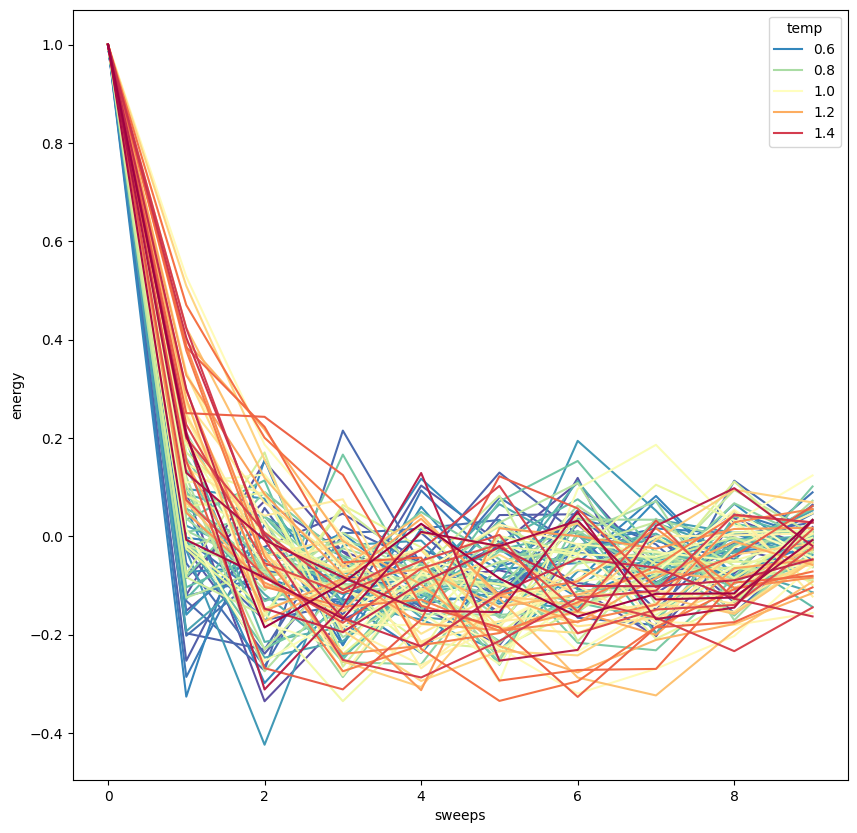

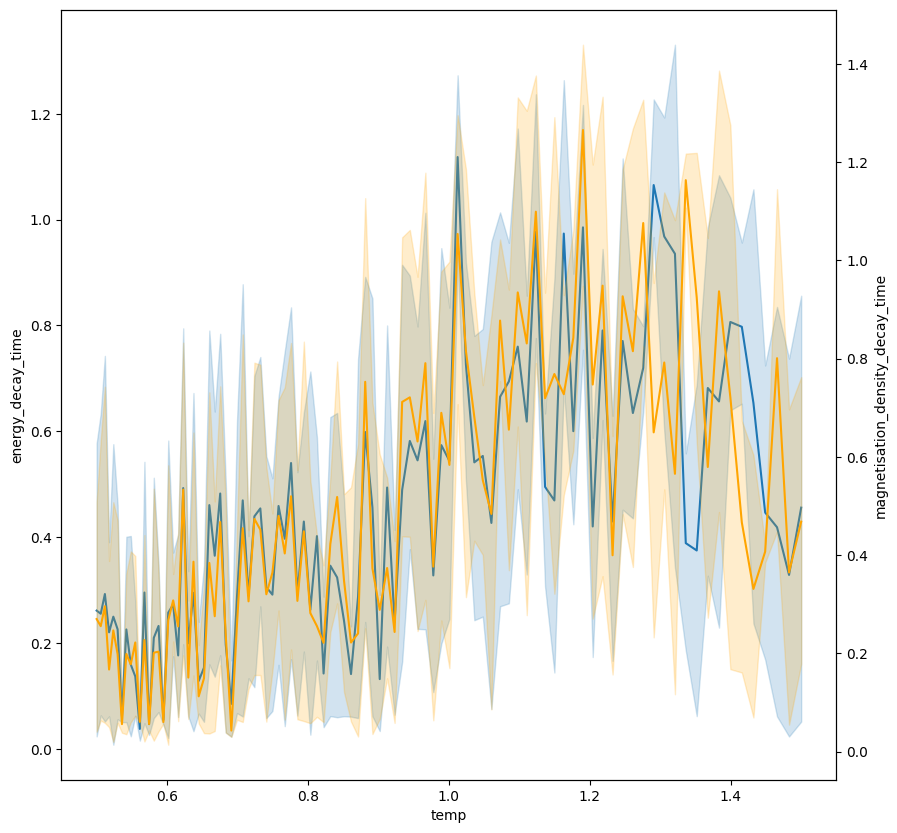

In [95]:
sns.lineplot(
    data=ac_df_expl,
    x="sweeps",
    y="energy",
    hue="temp",
    palette="Spectral_r",
    errorbar=None,
)
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

sns.lineplot(
    data=ac_df,
    x="temp",
    y="energy_decay_time",
    ax=ax1,
    # y=["energy_decay_time", "magnetisation_density_decay_time"])
)
sns.lineplot(
    data=ac_df,
    x="temp",
    y="magnetisation_density_decay_time",
    ax=ax2,
    color="orange",
    # y=["energy_decay_time", "magnetisation_density_decay_time"])
)
plt.show()

In [ ]:
a.dtypes

state.env.beta           float64
state.id_                  int64
state.steps                int64
state.sweeps               int64
steps                      int64
sweeps_per_step            int64
energy                    object
magnetisation_density     object
sweeps                    object
dtype: object

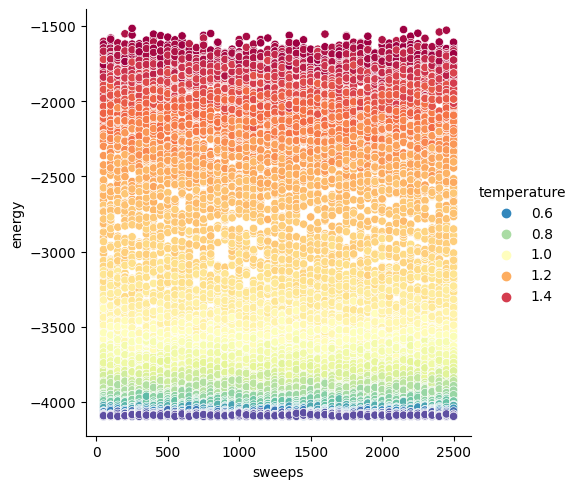

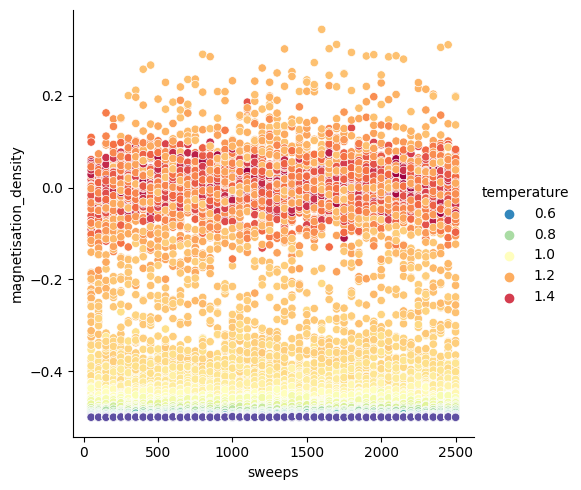

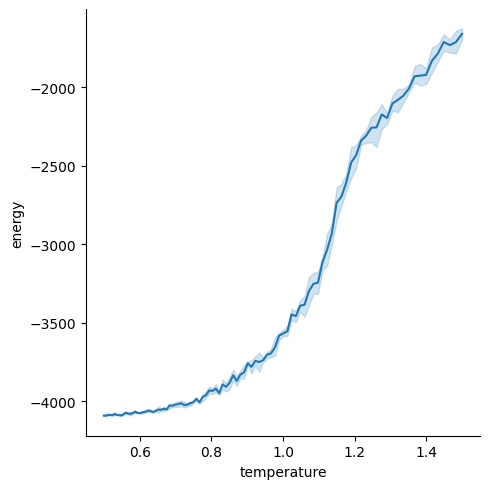

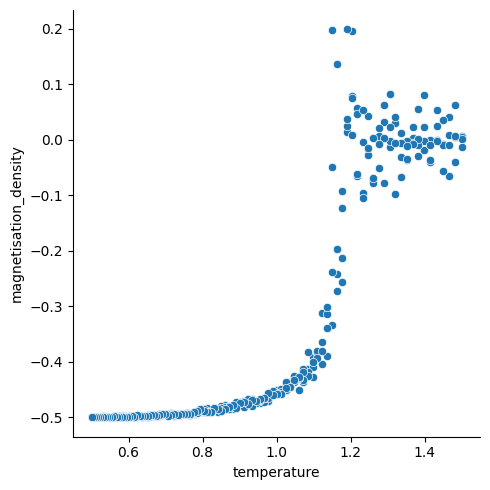

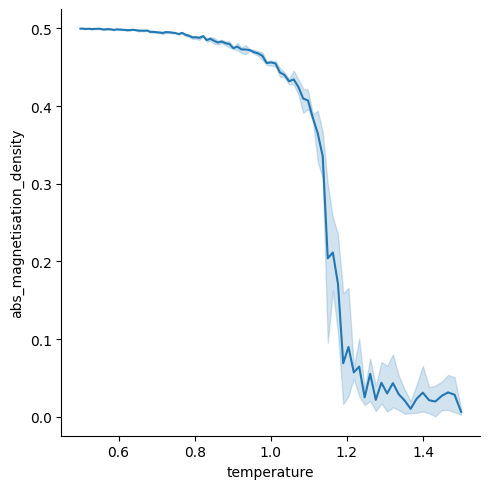

In [ ]:
sns.relplot(
    data=df,
    x="sweeps",
    y="energy",
    hue="temperature",
    palette="Spectral_r",
)
sns.relplot(
    data=df,
    x="sweeps",
    y="magnetisation_density",
    hue="temperature",
    palette="Spectral_r",
)

last_sweeps = df[df["sweeps"] == np.max(df["sweeps"])]
sns.relplot(
    data=last_sweeps,
    x="temperature",
    y="energy",
    # hue="beta",
    kind="line",
    # errorbar=None
)
sns.relplot(
    data=last_sweeps,
    x="temperature",
    y="magnetisation_density",
)
sns.relplot(
    data=last_sweeps,
    x="temperature",
    y="abs_magnetisation_density",
    kind="line",
    # errorbar=None
)

In [ ]:
df[df["steps"] == np.max(df["steps"])]

,steps,sweeps,state_id,energy,magnetisation_density,beta,temperature,abs_magnetisation_density
18816,10240000,2500,0,-1706.0,-0.012451,0.666667,1.500000,0.012451
18817,10240000,2500,1,-1628.0,-0.039551,0.674421,1.482753,0.039551
18818,10240000,2500,2,-1808.0,0.041992,0.682265,1.465705,0.041992
18819,10240000,2500,3,-1658.0,0.034912,0.690201,1.448853,0.034912
18820,10240000,2500,4,-1696.0,0.000244,0.698229,1.432194,0.000244
...,...,...,...,...,...,...,...,...
19195,10240000,2500,379,-4092.0,-0.499756,1.909592,0.523672,0.499756
19196,10240000,2500,380,-4088.0,-0.499512,1.931804,0.517651,0.499512
19197,10240000,2500,381,-4082.0,-0.499023,1.954273,0.511699,0.499023
19198,10240000,2500,382,-4092.0,-0.499756,1.977005,0.505816,0.499756


In [ ]:
temp_states = states_list[: c.n_temps]


@interact(value=0, min=0, max=len(temp_states))
def update(i=(0, len(temp_states) - 1)):
    fig = temp_states[i].plot()
    fig.set_size_inches(10, 10)
    fig.dpi = 100
    fig.show()

interactive(children=(IntSlider(value=47, description='i', max=95), Output()), _dom_classes=('widget-interact'…

In [ ]:
keys = k.shaped(states.vectorisation_shape)


@transforms(in_axes=(0, 0, None, None), out_axes=0)
def measure_equilibrium(key: RNGKey, state: State, num: int = 1, sweeps: int = 0):
    return state.evolve_and_measure_multiple(rng_key=key, num=num, sweeps=sweeps)


equil_measurements = measure_equilibrium(keys, states, 16, 50)

In [ ]:
measurement_keys = [
    "steps",
    "sweeps",
    "state_id",
    "energy",
    "magnetisation_density",
]
eq_measurements = {key: [] for key in measurement_keys}
for key in measurement_keys:
    data = getattr(equil_measurements, key).flatten().tolist()
    eq_measurements[key].extend(data)


@ft.cache
def id_to_beta(id_):
    idx = np.argwhere(states.id_ == id_).flatten()
    idx = tuple(idx)
    return float(states.env.beta[idx])


eq_df = pd.DataFrame(eq_measurements)
eq_df["beta"] = eq_df["state_id"].apply(id_to_beta)
eq_df["temperature"] = 1.0 / eq_df["beta"]
eq_df

,steps,sweeps,state_id,energy,magnetisation_density,beta,temperature
0,10444800,2550,0,-1722.0,-0.010498,0.666667,1.5
1,10444800,2550,0,-1650.0,0.020264,0.666667,1.5
2,10444800,2550,0,-1726.0,-0.012207,0.666667,1.5
3,10444800,2550,0,-1614.0,-0.012939,0.666667,1.5
4,10444800,2550,0,-1632.0,0.012451,0.666667,1.5
...,...,...,...,...,...,...,...
6139,10444800,2550,383,-4096.0,-0.500000,2.000000,0.5
6140,10444800,2550,383,-4084.0,-0.499268,2.000000,0.5
6141,10444800,2550,383,-4088.0,-0.499512,2.000000,0.5
6142,10444800,2550,383,-4092.0,-0.499756,2.000000,0.5


In [ ]:
# Create two dataframes of different 'shapes'
# sin_df: holds data that is defined on every state
# sum_df: holds data that requires grouping on states


sin_df = eq_df.copy()
sin_df["natural_temperature"] = 1.0 / sin_df["beta"]
sin_df["abs_magnetisation_density"] = np.abs(sin_df["magnetisation_density"])

sum_df = pd.DataFrame()


# Energy - Summarised
sum_df["energies_mean"] = eq_df.groupby(["state_id"])["energy"].mean()
sum_df["energies_var"] = eq_df.groupby(["state_id"])["energy"].var()

# Magnetisation Density - Summarised
sum_df["mag_dens_mean"] = eq_df.groupby(["state_id"])["magnetisation_density"].mean()
sum_df["mag_dens_var"] = eq_df.groupby(["state_id"])["magnetisation_density"].var()

# # Index
sum_df["state_id"] = sum_df.index

# Temperature + Coldness
sum_df["beta"] = sum_df["state_id"].apply(id_to_beta)
sum_df["temperature"] = beta_to_temp(sum_df["beta"])
sum_df["natural_temperature"] = 1.0 / sum_df["beta"]

# Heat Capacity
sum_df["heat_cap_gradient"] = np.abs(
    np.gradient(sum_df["energies_mean"], sum_df["temperature"])
)
sum_df["heat_cap_fluctuation"] = sum_df["energies_var"] / (
    constants.Boltzmann * np.square(sum_df["temperature"])
)

# Magnetic Susceptibility
sum_df["mag_sus_gradient"] = np.abs(
    np.gradient(sum_df["mag_dens_mean"], sum_df["temperature"])
)
sum_df["mag_sus_fluctuation"] = sum_df["mag_dens_var"] / (
    constants.Boltzmann * np.square(sum_df["temperature"])
)

# Binder cumulant
sin_df["mag_1"] = np.abs(eq_df["magnetisation_density"])
sin_df["mag_2"] = np.power(eq_df["magnetisation_density"], 2)
sin_df["mag_4"] = np.power(eq_df["magnetisation_density"], 4)

sum_df["mag_1_mean"] = sin_df.groupby("state_id")["mag_1"].mean()
sum_df["mag_2_mean"] = sin_df.groupby("state_id")["mag_2"].mean()
sum_df["mag_4_mean"] = sin_df.groupby("state_id")["mag_4"].mean()


# mag_2_mean = np.mean(mag_2)
# mag_4_mean = np.mean(mag_4)

sum_df["binder_2"] = 1 - sum_df["mag_2_mean"] / np.square(sum_df["mag_1_mean"])
sum_df["binder_4"] = 1.0 / 3.0 - sum_df["mag_4_mean"] / (
    3.0 * np.square(sum_df["mag_2_mean"])
)

In [ ]:
sum_df

,energies_mean,energies_var,mag_dens_mean,mag_dens_var,state_id,beta,temperature,natural_temperature,heat_cap_gradient,heat_cap_fluctuation,mag_sus_gradient,mag_sus_fluctuation,mag_1_mean,mag_2_mean,mag_4_mean,binder_2,binder_4
state_id,,,,,,,,,,,,,,,,,
0,-1673.625,2971.850000,0.002518,4.030523e-04,0,0.666667,1.086446e+23,1.500000,2.771866e-20,1.823592e-20,1.710135e-24,2.473217e-27,0.015945,0.000384,4.596947e-07,-5.110716e-01,-7.047512e-01
1,-1708.250,2234.066667,0.004654,5.980132e-04,1,0.674421,1.073954e+23,1.482753,1.077567e-20,1.402948e-20,8.202405e-26,3.755399e-27,0.019302,0.000582,1.107623e-06,-5.628702e-01,-7.555530e-01
2,-1700.875,6700.783333,0.002365,7.991848e-04,2,0.682265,1.061606e+23,1.465705,1.696147e-20,4.306413e-20,1.103748e-24,5.136145e-27,0.022598,0.000755,1.407301e-06,-4.780823e-01,-4.899854e-01
3,-1749.250,5061.266667,0.001923,1.426370e-03,3,0.690201,1.049400e+23,1.448853,3.616474e-20,3.328848e-20,1.759328e-25,9.381384e-27,0.031616,0.001341,3.813201e-06,-3.414752e-01,-3.735761e-01
4,-1788.750,2053.266667,0.002777,1.259779e-03,4,0.698229,1.037334e+23,1.432194,3.335056e-20,1.382053e-20,2.665364e-24,8.479568e-27,0.026245,0.001189,4.013177e-06,-7.258194e-01,-6.133012e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,-4087.375,40.383333,-0.499451,1.788139e-07,379,1.909592,3.792941e+22,0.523672,4.587850e-22,2.033138e-21,3.639764e-26,9.002559e-30,0.499451,0.249451,6.222604e-02,-6.720281e-07,-8.959195e-07
380,-4086.000,63.466667,-0.499374,2.620121e-07,380,1.931804,3.749330e+22,0.517651,6.199786e-22,3.270055e-21,5.543734e-26,1.349990e-29,0.499374,0.249375,6.218815e-02,-9.850087e-07,-1.311796e-06
381,-4087.875,25.850000,-0.499496,9.909272e-08,381,1.954273,3.706222e+22,0.511699,3.932361e-21,1.363059e-21,2.308028e-25,5.225113e-30,0.499496,0.249497,6.224875e-02,-3.723473e-07,-4.962651e-07


In [ ]:
sin_df

,steps,sweeps,state_id,energy,magnetisation_density,beta,temperature,natural_temperature,abs_magnetisation_density,mag_1,mag_2,mag_4
0,10444800,2550,0,-1722.0,-0.010498,0.666667,1.5,1.5,0.010498,0.010498,0.000110,1.214602e-08
1,10444800,2550,0,-1650.0,0.020264,0.666667,1.5,1.5,0.020264,0.020264,0.000411,1.686058e-07
2,10444800,2550,0,-1726.0,-0.012207,0.666667,1.5,1.5,0.012207,0.012207,0.000149,2.220446e-08
3,10444800,2550,0,-1614.0,-0.012939,0.666667,1.5,1.5,0.012939,0.012939,0.000167,2.803262e-08
4,10444800,2550,0,-1632.0,0.012451,0.666667,1.5,1.5,0.012451,0.012451,0.000155,2.403482e-08
...,...,...,...,...,...,...,...,...,...,...,...,...
6139,10444800,2550,383,-4096.0,-0.500000,2.000000,0.5,0.5,0.500000,0.500000,0.250000,6.250000e-02
6140,10444800,2550,383,-4084.0,-0.499268,2.000000,0.5,0.5,0.499268,0.499268,0.249268,6.213459e-02
6141,10444800,2550,383,-4088.0,-0.499512,2.000000,0.5,0.5,0.499512,0.499512,0.249512,6.225622e-02
6142,10444800,2550,383,-4092.0,-0.499756,2.000000,0.5,0.5,0.499756,0.499756,0.249756,6.237802e-02


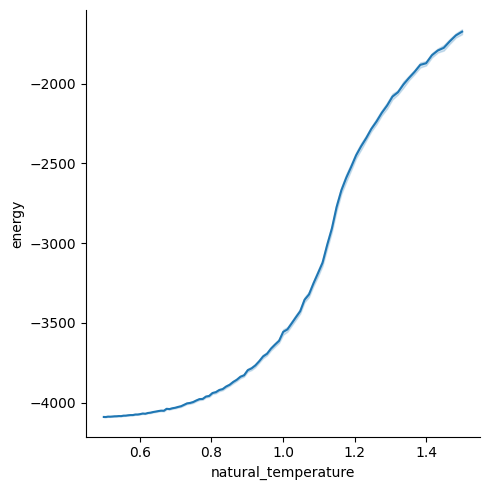

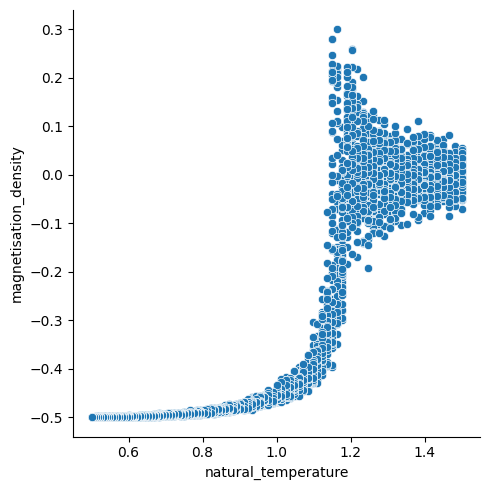

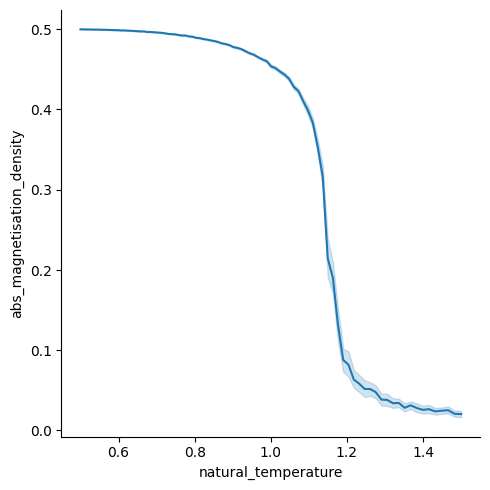

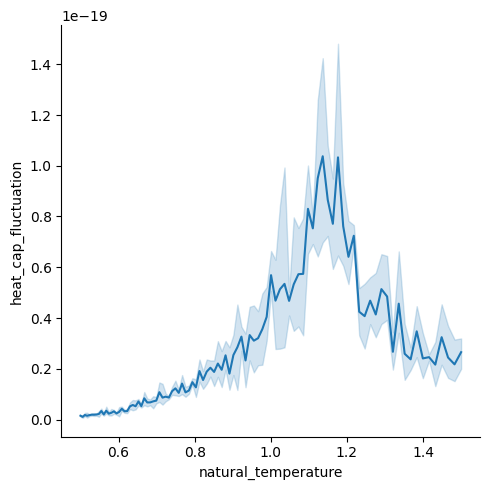

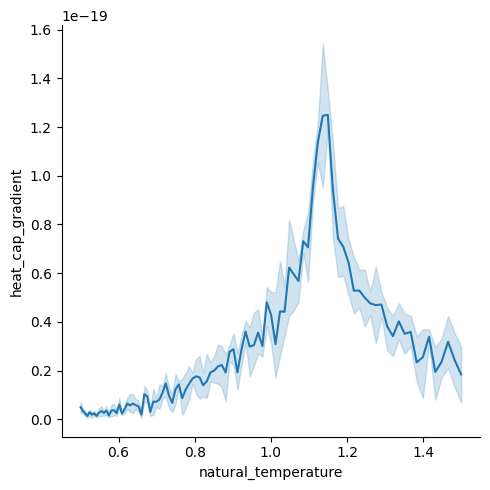

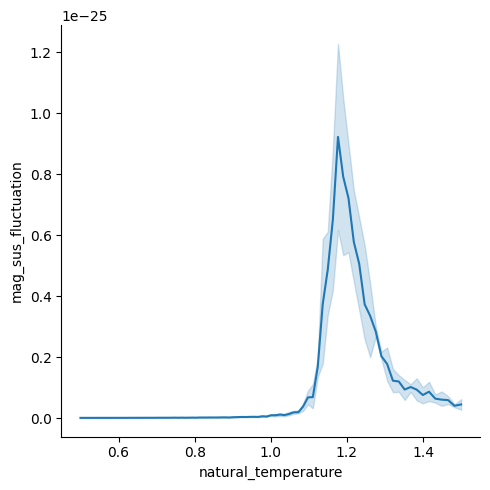

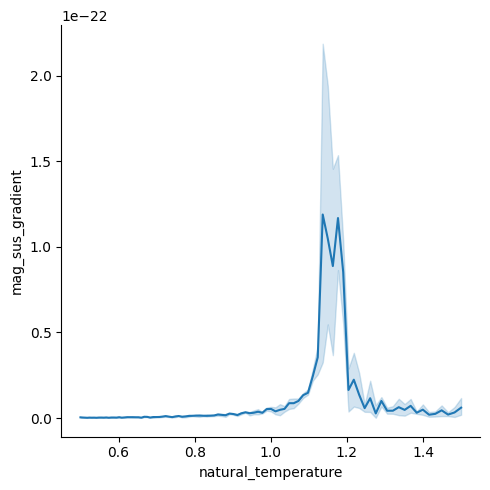

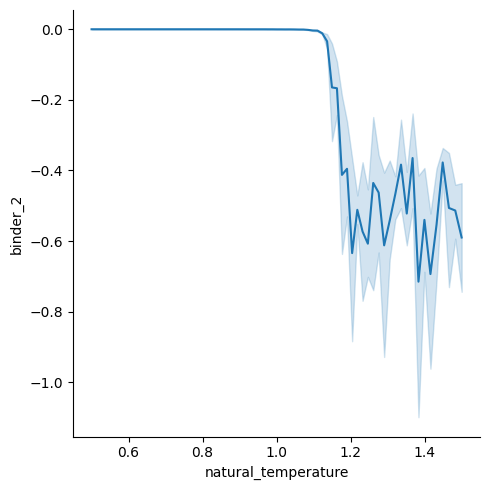

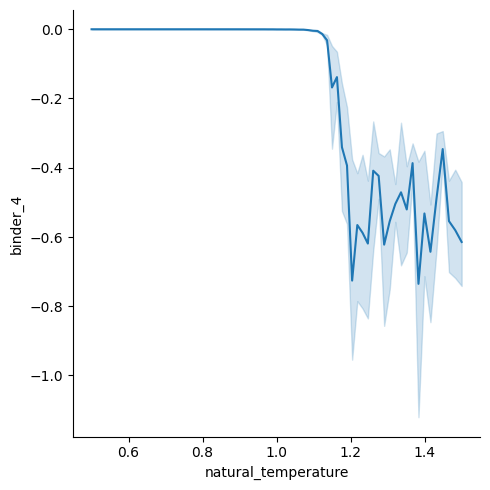

In [ ]:
sns.relplot(
    data=sin_df,
    x="natural_temperature",
    y="energy",
    kind="line",
)
sns.relplot(
    data=sin_df,
    x="natural_temperature",
    y="magnetisation_density",
    # kind="line",
)
sns.relplot(
    data=sin_df,
    x="natural_temperature",
    y="abs_magnetisation_density",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="heat_cap_fluctuation",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="heat_cap_gradient",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="mag_sus_fluctuation",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="mag_sus_gradient",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="binder_2",
    kind="line",
)
sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="binder_4",
    kind="line",
)